In [1]:
from iotasks import calling_metadata, second_to_last_file, read_file_string
#cwd, call, host, githash =  calling_metadata()
#print 'On %s in directory %s with git-hash %s.'%(host, cwd, githash)

ImportError: No module named iotasks

In [5]:
# this script plots either YZ sections at a specfic x or zonal-means

# set the file names
rootdir = '/net/scratch1/pwolfram/ZISO_10km/'
meshFile = rootdir + 'mesh.nc'
initFile = rootdir + 'init.nc'
forcingFile = rootdir + 'forcing.nc'
#outputFile = second_to_last_file(rootdir+'output/output.*.nc')
outputFile = rootdir+'output/output.0015-12-01_00.00.00.nc'

## if zonalMean = True
#outputFileAvg = second_to_last_file(rootdir+'analysis_members/timeSeriesStats.*.nc')
#print outputFile
outputFileAvg = rootdir+'analysis_members/timeSeriesStats.0015-12-01.nc'

# pick a time level (note, first time record is zero)
iTime = 0

# set logical for zonal mean (if false (0), must then set iSection)
zonalMean = False
iSection = 30

# this script assumes a perfect hexagonal grid
# so nCells = nX * nY, set nX and nY
#nX = 100
#nY = 228
import xray
dsmesh = xray.open_dataset(meshFile)
dsmesh = dsmesh.set_coords(['xCell','yCell'])
nX = dsmesh.xCell.groupby('yCell').count().values[0]
nY = len(dsmesh.xCell.groupby('yCell').count())
print 'nX = %d nY = %d'%(nX,nY)

#set some reference potential density
potentialDensityOffset = 1029.0

nX = 100 nY = 228


In [3]:
from netCDF4 import Dataset                     # For reading data
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt                 # For plotting
import numpy.ma as ma
# Place figures within document
%pylab inline
pylab.rcParams['figure.figsize'] = (18.0, 10.0) # Large figures

Populating the interactive namespace from numpy and matplotlib


In [4]:
#plotting rules
axis_font = {'fontname':'Arial', 'size':'18'}    
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

if zonalMean==1:
    titlePrefix = 'zonal-mean: '
else:
    titlePrefix = 'section at i = ' + str(iSection) + ': '
    
print titlePrefix

section at i = 30: 


In [6]:
meshData = Dataset(meshFile)
initData = Dataset(initFile)
forcingData = Dataset(forcingFile)
outputData = Dataset(outputFile)
outputDataAvg = Dataset(outputFileAvg)

nCells = len(meshData.dimensions['nCells']);
nVertices = len(meshData.dimensions['nVertices']);
nEdges = len(meshData.dimensions['nEdges']);
nVertLevels = len(outputData.dimensions['nVertLevels']);
nTime = len(outputData.dimensions['Time']);

print 'mesh file: ', meshFile
print 'init file: ', initFile
print 'forcing file: ', forcingFile
print 'output file: ', outputFile
print ' '
print 'nCells: ', nCells
print 'nVertices: ', nVertices
print 'nEdges: ', nEdges
print 'nVertLevels: ', nVertLevels
print 'nTime: ', nTime

mesh file:  /net/scratch1/pwolfram/ZISO_10km/mesh.nc
init file:  /net/scratch1/pwolfram/ZISO_10km/init.nc
forcing file:  /net/scratch1/pwolfram/ZISO_10km/forcing.nc
output file:  /net/scratch1/pwolfram/ZISO_10km/output/output.0015-12-01_00.00.00.nc
 
nCells:  22800
nVertices:  45800
nEdges:  68600
nVertLevels:  100
nTime:  1


In [7]:
print ' assuming perfect hexagonal grid'
print '    number of grid cells in x-direction: ', nX
print '    number of grid cells in y-direction: ', nY

 assuming perfect hexagonal grid
    number of grid cells in x-direction:  100
    number of grid cells in y-direction:  228


In [8]:
#get grid information
xCell = meshData.variables['xCell'][:];
yCell = meshData.variables['yCell'][:];

xIndex = range(0,nX)
yIndex = range(0,nY)

xCell = xCell.reshape(nY,nX)
yCell = yCell.reshape(nY,nX)
xCell = np.array(xCell)
yCell = np.array(yCell)

xPosition=[]
for i in range(0,nX):
    xData = xCell[1,i] / 1000.0
    xPosition.append(xData)
    
yPosition=[]
for j in range(0,nY):
    yData = yCell[j,1] / 1000.0
    yPosition.append(yData)
       
refZMid = outputData.variables['refZMid'][:]

xPosition = np.array(xPosition)
yPosition = np.array(yPosition)
zPosition = np.array(refZMid)

(22800, 100)


/usr/projects/climate/SHARED_CLIMATE/anaconda_envs/default-2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


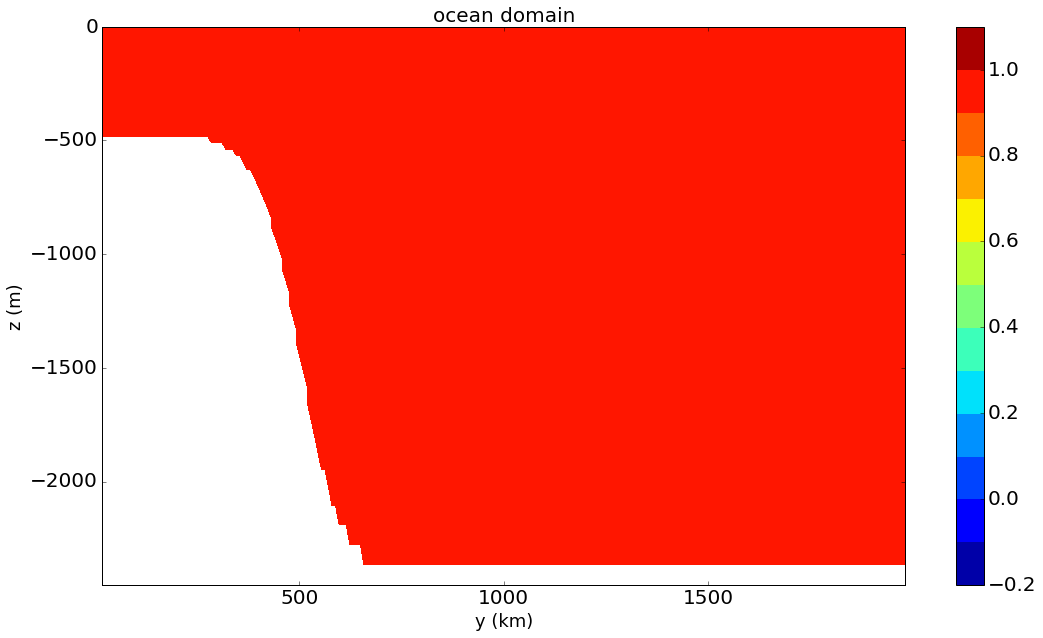

In [9]:
#get 3D ocean mask based on maxLevelCell

maxLevelCell = outputData.variables['maxLevelCell'][:]

oceanMask=[]
for iCell in range(0,nCells):
    for k in range(0,maxLevelCell[iCell]):
        oceanMask.append(1)
    for k in range(maxLevelCell[iCell],nVertLevels):
        oceanMask.append(NaN)
    
oceanMask = np.array(oceanMask)
oceanMask = oceanMask.reshape(nCells,nVertLevels)
print oceanMask.shape
oceanMask = oceanMask.reshape(nY,nX,nVertLevels)

minVal = -0.2
maxVal = 1.2
incVal = 0.1
plotData = oceanMask[:,iSection,:]
plt.contourf(yPosition, zPosition, plotData.T, levels=numpy.arange(minVal,maxVal,incVal));
plt.colorbar();
plt.title('ocean domain', **title_font)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('z (m)', **axis_font)

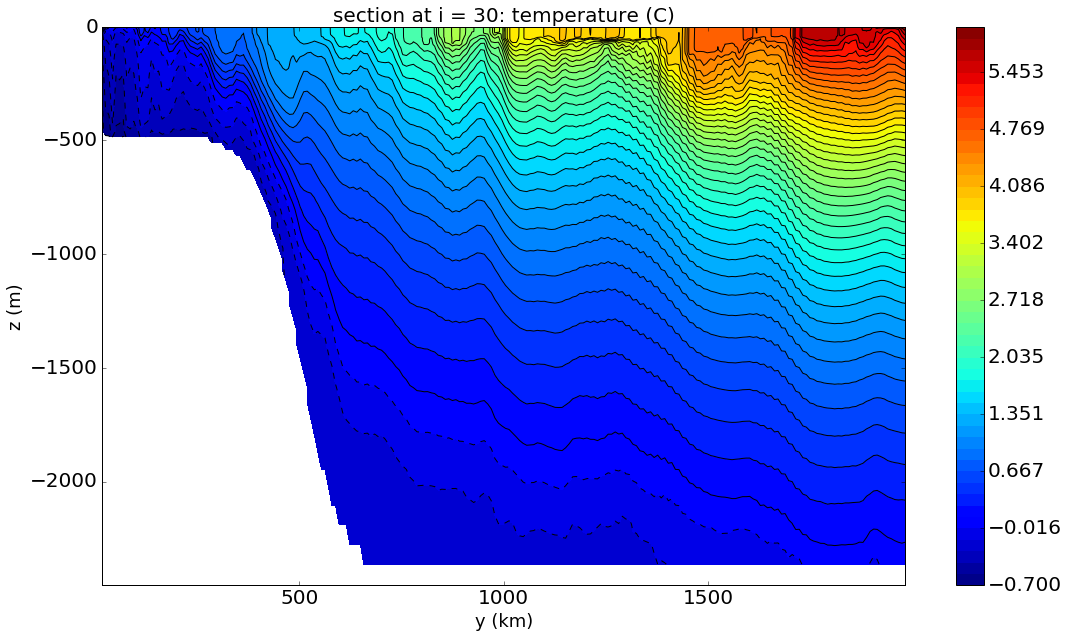

In [11]:
#temperature
if zonalMean:
    temperature = outputDataAvg.variables['timeSeriesStats_avg_activeTracers_1_temperature'][iTime,:,:]
else:
    temperature = outputData.variables['temperature'][iTime,:,:]
temperature = temperature.reshape(nY,nX,nVertLevels)

temperature = np.multiply(temperature,oceanMask)
minVal = -1.0
maxVal = 7.0
incVal = 0.25

if zonalMean:
    sumData = np.sum(temperature, axis=1)
    print sumData.shape, nX
    sumData = np.divide(sumData,nX)
    plotData = sumData
    figTitle = titlePrefix + 'temperature (C)'
else:
    plotData = temperature[:,iSection,:];
    figTitle = titlePrefix + 'temperature (C)'

plt.contourf(yPosition, zPosition, plotData.T, levels=numpy.linspace(-0.7,6,50));
plt.colorbar();
plt.contour(yPosition, zPosition, plotData.T, levels=numpy.linspace(-0.7,6,50), colors='k');
plt.title(figTitle, **title_font)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('z (m)', **axis_font)

In [27]:
1392640*4-6

5570554

In [22]:
init=87
tri=
for i in range(8):
    init = init*4 - 6
    print init

342
1362
5442
21762
87042
348162
1392642
5570562


0.710999998966


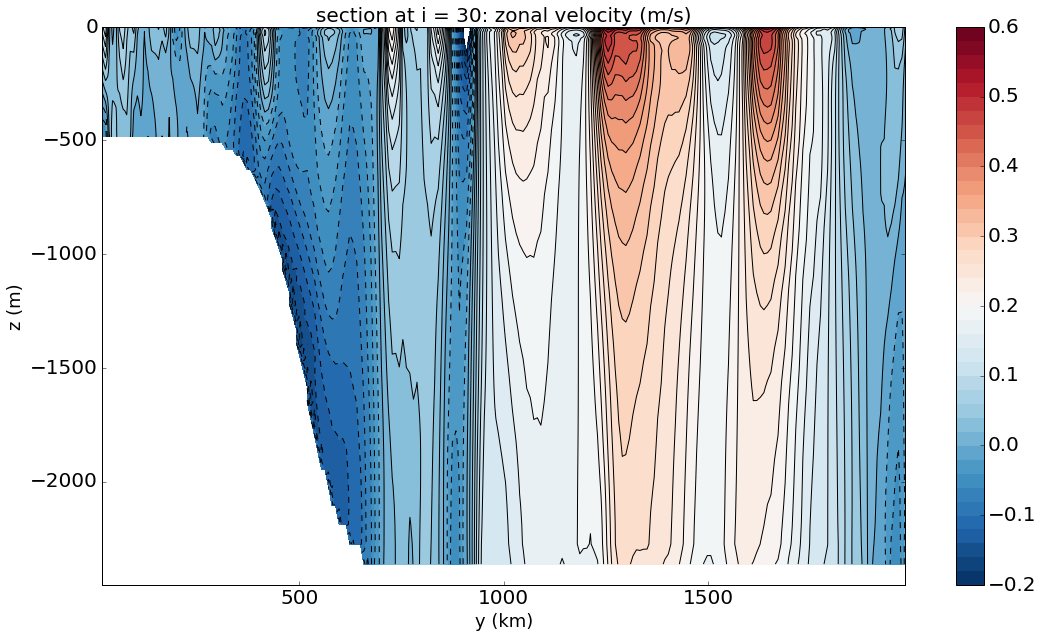

In [20]:
#zonal velocity
#if zonalMean:
velocityZonal = outputDataAvg.variables['timeSeriesStats_avg_velocityZonal_1'][iTime,:,:]
colorLevels = linspace(-0.2, 0.6, 41)
contourLevels = linspace(-0.2, 0.6, 41)
#else:
#velocityZonal = outputData.variables['velocityZonal'][iTime,:,:]
#colorLevels = linspace(-1.0, 1.0, 51)
#ontourLevels = linspace(-1.0, 1.0, 21)
    
print velocityZonal.max()
velocityZonal = velocityZonal.reshape(nY,nX,nVertLevels)
velocityZonal = np.multiply(velocityZonal,oceanMask)

if zonalMean:
    sumData = np.sum(velocityZonal, axis=1);
    sumData = np.divide(sumData,nX)
    plotData = sumData
    figTitle = titlePrefix + 'zonal velocity (m/s)'
else:
    plotData = velocityZonal[:,iSection,:];
    figTitle = titlePrefix + 'zonal velocity (m/s)'

#colorLevels = np.linspace(-0.3,0.3,50)
plt.contourf(yPosition, zPosition, plotData.T, levels=colorLevels,cmap='RdBu_r');
plt.colorbar();
plt.contour(yPosition, zPosition, plotData.T, levels=contourLevels, colors='k');
plt.title(figTitle, **title_font)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('z (m)', **axis_font)


In [ ]:
#meridional velocity
if zonalMean:
    velocityMeridional = outputDataAvg.variables['timeSeriesStats_avg_velocityMeridional_1'][iTime,:,:]
    minVal = -0.1
    maxVal = 0.2
    incVal = 0.01
else:
    velocityMeridional = outputData.variables['velocityMeridional'][iTime,:,:]
    minVal = -1.0
    maxVal = 1.0
    incVal = 0.1
velocityMeridional = velocityMeridional.reshape(nY,nX,nVertLevels)

velocityMeridional = np.multiply(velocityMeridional,oceanMask)


if zonalMean==1:
    sumData = np.sum(velocityMeridional, axis=1);
    sumData = np.divide(sumData,nX)
    plotData = sumData
    figTitle = titlePrefix + 'meridional velocity (m/s)'
else:
    plotData = velocityMeridional[:,iSection,:];
    figTitle = titlePrefix + 'meridional velocity (m/s)'

plt.contourf(yPosition, zPosition, plotData.T, levels=numpy.arange(minVal,maxVal,incVal));
plt.colorbar();
plt.contour(yPosition, zPosition, plotData.T, levels=numpy.arange(minVal,maxVal,incVal), colors='k');
plt.title(figTitle, **title_font)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('z (m)', **axis_font)

In [ ]:
#kinetic energy 
if zonalMean:
    kineticEnergyCell = outputDataAvg.variables['timeSeriesStats_avg_kineticEnergyCell_1'][iTime,:,:]
    colorLevels = linspace(0.0,.2,41)
    contourLevels = linspace(0.0,0.2,41)
else:
    kineticEnergyCell = outputData.variables['kineticEnergyCell'][iTime,:,:]
    colorLevels = linspace(0.0,.5,26)
    contourLevels = linspace(0.0,0.5,11)
kineticEnergyCell = kineticEnergyCell.reshape(nY,nX,nVertLevels)

kineticEnergyCell = np.multiply(kineticEnergyCell,oceanMask)

if zonalMean==1:
    sumData = np.sum(kineticEnergyCell, axis=1);
    sumData = np.divide(sumData,nX)
    plotData = sumData
    figTitle = titlePrefix + 'kinetic energy (m2/s2)'
else:
    plotData = kineticEnergyCell[:,iSection,:];
    figTitle = titlePrefix + 'kinetic energy (m2/s2)'

plt.contourf(yPosition, zPosition, (plotData.T), levels=colorLevels);
plt.colorbar();
plt.contour(yPosition, zPosition, (plotData.T), levels=contourLevels, colors='k');
plt.title(figTitle, **title_font)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('z (m)', **axis_font)

In [ ]:
#potential density 
if zonalMean:
    potentialDensity = outputDataAvg.variables['timeSeriesStats_avg_density_1'][iTime,:,:]
else:
    potentialDensity = outputData.variables['potentialDensity'][iTime,:,:]
potentialDensity = potentialDensity.reshape(nY,nX,nVertLevels) - potentialDensityOffset

potentialDensity = np.multiply(potentialDensity,oceanMask)
minVal = -1.0
maxVal = +1.6
incVal = 0.05

if zonalMean==1:
    sumData = np.sum(potentialDensity, axis=1);
    sumData = np.divide(sumData,nX)
    plotData = sumData
    figTitle = titlePrefix + 'potential density (kg/m3)'
else:
    plotData = potentialDensity[:,iSection,:];
    figTitle = titlePrefix + 'potential density (kg/m3)'

plt.contourf(yPosition, zPosition, plotData.T, levels=numpy.arange(minVal,maxVal,incVal));
plt.colorbar();
plt.contour(yPosition, zPosition, plotData.T, levels=numpy.arange(minVal,maxVal,incVal), colors='k');
plt.title(figTitle, **title_font)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('z (m)', **axis_font)

In [ ]:
#BruntVaisalaFreqTop  
if zonalMean:
    BruntVaisalaFreqTop = outputDataAvg.variables['timeSeriesStats_avg_BruntVaisalaFreqTop_1'][iTime,:,:]
    colorLevels = linspace(-8.0,-4.0,41)
    contourLevels = linspace(-8.0, -4.0, 41)
else:
    BruntVaisalaFreqTop = outputData.variables['BruntVaisalaFreqTop'][iTime,:,:]
    colorLevels = linspace(-8.0,-4.0,41)
    contourLevels = linspace(-8.0, -4.0, 41)
    
BruntVaisalaFreqTop = BruntVaisalaFreqTop.reshape(nY,nX,nVertLevels)
BruntVaisalaFreqTop = np.multiply(BruntVaisalaFreqTop,oceanMask)

if zonalMean==1:
    sumData = np.sum(BruntVaisalaFreqTop, axis=1);
    sumData = np.divide(sumData,nX)
    plotData = sumData
    figTitle = titlePrefix + 'BVF $(s^{-2})$'
else:
    plotData = BruntVaisalaFreqTop[:,iSection,:];
    figTitle = titlePrefix + 'BVF $(s^{-2})$'

plt.contourf(yPosition, zPosition, log10(plotData.T),levels=colorLevels);
plt.colorbar();
#plt.contour(yPosition, zPosition, -log10(plotData.T), levels=-contourLevels, colors='k');
plt.title(figTitle, **title_font)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('z (m)', **axis_font)